In [363]:
import io
import json
import os
import sys
import pandas as pd

import numpy as np
from scipy import stats
import datetime
import time
import statistics as st
import tqdm
import re
import catboost

from sqlalchemy import create_engine,ForeignKey
from sqlalchemy.orm import declarative_base,relationship
from sqlalchemy import Column, Integer, String, Boolean, BIGINT, TEXT, INT, FLOAT, BOOLEAN
from sqlalchemy.dialects.sqlite import DATETIME
from sqlalchemy.orm import Session
Base = declarative_base()

import matplotlib.pyplot as plt

engine = create_engine("sqlite:///test.sqlite", echo=False)

In [622]:
pd.read_sql("SELECT * FROM courses WHERE date BETWEEN '2022-01-01' AND '2022-24-22' ORDER BY date", con=engine).to_csv("../courses.csv")

In [364]:
df = pd.read_sql("SELECT * FROM partants WHERE date BETWEEN '2019-01-01' AND '2022-12-22' ORDER BY date", con=engine)
#df2 = pd.read_csv("today_data.csv", index_col=0)

In [365]:
#df = pd.concat([df, df2], ignore_index=True)

In [366]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values(["date","rid","numPmu"], inplace=True)
df.reset_index(drop=True, inplace=True)
# df["accel500m"] = (df["reducLast1000m"] - df["reducLast500m"])
df[["rid","nom","classement","gainCourse"]].tail()

,rid,nom,classement,gainCourse
213607,2022122253078,GHOSTBUSTER,3,4620
213608,2022122253078,FLOPY RUSH,8,0
213609,2022122253078,DESTIN DE STAR,0,0
213610,2022122253078,EIGHT,7,330
213611,2022122253078,FAHRENHEIT FLOWER,0,0


In [367]:
df["lastRace"] = df.groupby("nom")["date"].transform(lambda x: x - x.shift(1))
df["lastRace_driver"] = df.groupby("driver_id")["date"].transform(lambda x: x - x.shift(1))
df["lastRace"] = df["lastRace"].apply(lambda x: x.days)
df["lastRace_driver"] = df["lastRace_driver"].apply(lambda x: x.days)
df["lastRace"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
213607    127.0
213608     10.0
213609     42.0
213610      4.0
213611     36.0
Name: lastRace, Length: 213612, dtype: float64

In [368]:
df["classement"] = pd.to_numeric(df["classement"],errors="coerce").fillna(10).astype(int)
df["classement"].replace(0, 10, inplace=True)
df["classement"]

df["classLastRace_horse"] = df.groupby("nom")["classement"].transform(lambda x: x.shift(1))
df["classLastRace_driver"] = df.groupby("driver_id")["classement"].transform(lambda x: x.shift(1))



In [369]:
df["win"] = df["classement"] == 1
df["place"] = df["classement"] <= 3

In [370]:
groupnom = df.groupby("nom")
groupdriver = df.groupby("driver_id")
grouptrainer = df.groupby("trainer_id")

dict_group = {"horse": groupnom, "driver": groupdriver, "trainer": grouptrainer}

for group in dict_group:
    df["weightDist"] = np.max((df["gainCourse"].to_numpy(), np.ones(len(df["gainCourse"]))), axis=0)
    weightDistSum = dict_group[group]["weightDist"].transform(lambda x: x.shift(1).rolling(20, min_periods=1).sum())
    df["distProd"] = df["weightDist"] * df["dist"]
    distProdSum = dict_group[group]["distProd"].transform(lambda x: x.shift(1).rolling(20, min_periods=1).sum())
    df[f"preferedDist_{group}"] =  distProdSum/weightDistSum 
    df[f"distToPreferedDist_{group}"] =  df["dist"] - df[f"preferedDist_{group}"] 

In [371]:
df[["nom","driver_id","trainer_id","dist","distToPreferedDist_horse","preferedDist_horse","preferedDist_trainer"]]

,nom,driver_id,trainer_id,dist,distToPreferedDist_horse,preferedDist_horse,preferedDist_trainer
0,EXTRA MOSSA,bGZ8YgIAZg,bGZ8YgIAZg,2850,NaN,NaN,NaN
1,ELVIS DES GLENAN,YWJ9YAQHYg,YWd3ZAsFaA,2850,NaN,NaN,NaN
2,ESPERADO,YWd9ZQECdA,YWd9ZQECdA,2850,NaN,NaN,NaN
3,ELEGANT FARCAP,Y2J6YwUDdw,YmF2YAMAfA,2850,NaN,NaN,NaN
4,EDDY DES MULOTTES,YWd4YgMGZA,YWR3YwEAYg,2850,NaN,NaN,NaN
...,...,...,...,...,...,...,...
213607,GHOSTBUSTER,Y2t9ZQIAZQ,Y2t9bQUFZA,2600,-75.655856,2675.655856,2611.564571
213608,FLOPY RUSH,Y2J9YgsGaA,Zmt8YgAAag,2600,-174.172994,2774.172994,2832.674447
213609,DESTIN DE STAR,YGt2ZQQIcw,YGt2ZQQIcw,2600,-168.811093,2768.811093,2785.670635
213610,EIGHT,YGt7ZAcCfg,YGt7ZAcCfg,2600,43.083905,2556.916095,2074.919355


In [372]:
df["lastRaceDist_horse"] = groupnom["dist"].transform(lambda x: x.shift(1))

df["tauxVictoire_horse"] = df["nombreVictoires"] / df["nombreCourses"]
df["gainDiffAnneeEnCours"] = df["gainsParticipant_gainsAnneeEnCours"] / df["gainsParticipant_gainsAnneePrecedente"]

In [373]:
df["nombreVictoires_couple"] = df.groupby(["nom", "driver_id"])["win"].transform(lambda x: x.shift(1).rolling(100, min_periods=1).sum())
df["nombrePlaces_couple"] = df.groupby(["nom", "driver_id"])["place"].transform(lambda x: x.shift(1).rolling(100, min_periods=1).sum())
df["nombreCourses_couple"] = df.groupby(["nom", "driver_id"])["win"].transform(lambda x: x.shift(1).rolling(100, min_periods=1).count())

df["tauxReussite_couple"] = df["nombrePlaces_couple"] / df["nombreCourses_couple"] 

In [496]:
df["jockeyConnu"] = (df["nombreCourses_couple"] > 3).astype(int)

In [375]:
df.loc[df["jockeyConnu"] == 1][["date","nom","driver_id","classement","tauxReussite_couple","nombreVictoires_couple","nombrePlaces_couple","nombreCourses_couple"]]

,date,nom,driver_id,classement,tauxReussite_couple,nombreVictoires_couple,nombrePlaces_couple,nombreCourses_couple
4001,2019-02-05,CASH DES CAILLONS,YmtbYwIDaw,1,0.500000,1.0,2.0,4.0
5819,2019-02-19,CASH DES CAILLONS,YmtbYwIDaw,1,0.600000,2.0,3.0,5.0
5887,2019-02-19,FLO DE MAX,Ymp4YQYAaw,1,0.000000,0.0,0.0,4.0
5892,2019-02-19,FABULEUSE MAUVE,YmJ2ZwMAdA,8,0.000000,0.0,0.0,4.0
5893,2019-02-19,FAVORITE D'ATOUT,Z2Z5YwYGcA,10,0.000000,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...
213604,2022-12-22,GOLDEN VISAIS,ZWJ6ZAEEdQ,1,0.250000,1.0,2.0,8.0
213605,2022-12-22,GINKO DU ROUSSOIR,Z2JaZQICcA,9,0.416667,3.0,5.0,12.0
213606,2022-12-22,FILARETE DU VERGER,Zmd2YAEAeQ,4,0.466667,5.0,14.0,30.0
213608,2022-12-22,FLOPY RUSH,Y2J9YgsGaA,8,0.222222,0.0,4.0,18.0


In [376]:
df["distPremMean"] = df.groupby("nom")["distPremArriv"].transform(lambda x: x.rolling(5, min_periods=1).mean(skipna=True).fillna(method='bfill'))

In [377]:
def parse_musique(mus):
    res = re.findall(r'([0-9D])a',mus)
    res = list(map(lambda x: int(x.replace("0", "10").replace("D", "10")), res))
    if len(res) >0:
        return res
    else:
        return [0]

In [378]:
df["meanMusic"] = df["musique"].apply(lambda x: np.mean(parse_musique(x)))
df["medianMusic"] = df["musique"].apply(lambda x: np.median(parse_musique(x)))
df["minMusic"] = df["musique"].apply(lambda x: np.min(parse_musique(x)))

df["distPremArriv"].replace(9999.0, np.nan, inplace=True)

sexe_unique = df["sexe"].unique()
df["sexe"].replace(sexe_unique, list(range(len(sexe_unique))), inplace=True)

race_unique = df["race"].unique()
df["race"].replace(race_unique, list(range(len(race_unique))), inplace=True)

In [379]:
for group in dict_group:
    df[f"meanReduc1500m_{group}"] = dict_group[group]["reduc1500m"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())
    df[f"meanReduc1000m_{group}"] = dict_group[group]["reduc1000m"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())
    df[f"meanReduc500m_{group}"] = dict_group[group]["reduc500m"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())
    df[f"meanReduc2000m_{group}"] = dict_group[group]["reduc2000m"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())
    df[f"meanReducLast1000m_{group}"] = dict_group[group]["reducLast1000m"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())
    df[f"meanReducLast500m_{group}"] = dict_group[group]["reducLast500m"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())
    df[f"accel500m_{group}"] = df[f"meanReduc500m_{group}"]/df[f"meanReduc1000m_{group}"]
    df[f"accelLast500m_{group}"] = df[f"meanReducLast500m_{group}"]/df[f"meanReducLast1000m_{group}"]
    

In [380]:
#df["accel500m"] = df["meanReduc500m"]/df["meanReduc1000m"]

In [381]:
df["meanDistPremArriv"] = df.groupby("nom")["distPremArriv"].transform(lambda x: x.shift(1).ewm(5, min_periods=1).mean())

df["meanDistPremArriv"].fillna(df["distPremArriv"].max(), inplace=True)


In [495]:
df["bestRecordInRace"] = df.groupby("rid")["recordAbs"].transform(lambda x: x == x.min()).astype(int)

In [492]:
set(list(df)) - set(features)

{'accel500m',
 'accelLast500m_driver',
 'accelLast500m_horse',
 'accelLast500m_trainer',
 'allure',
 'avisEntraineur',
 'avisTrainer',
 'class1000m',
 'class1500m',
 'class2000m',
 'class500m',
 'classement',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_type

In [35]:
df["nombreCourses"].unique()

array([ 16,   8,  17,  12,  13,  11,   9,  21,  26,  33,  24,  19,  20,
        18,  15,  25,  23,  40,  37,  27,   2,  32,   6,  35,   0,  38,
        34,  69,  41,  36,  28,  64,  60,  70,  85,  71,  86,  97,  56,
        66,  72,  99,  51,  49,  79,   1,   5,   3,   7,   4,  10,  31,
        22,  14,  65,  53,  59,  29,  73,  57,  54,  76, 116, 110,  45,
        63, 118, 137, 106, 113,  44,  30,  42,  47,  50,  43,  55,  48,
        84,  46,  94,  52,  68,  90, 105,  77,  80,  89, 112,  87,  88,
        83,  81,  75,  91,  92,  58,  61,  82, 108, 103,  95,  39,  74,
       109,  62, 141,  93, 111,  96, 107, 123, 138,  67, 136,  98, 132,
       101,  78, 114, 104, 119, 115, 125, 129, 100, 124, 126, 133, 139,
       130, 131, 134, 128, 120, 102, 117, 121, 190, 191, 143, 144, 161,
       122, 194, 142, 163, 146, 164, 147, 145, 198, 199, 149, 200, 201,
       127, 166, 148, 152, 168, 150, 169, 153, 140, 204, 154, 205, 135,
       206, 156, 208, 209, 175, 157, 210, 212, 214, 158, 217, 22

In [565]:
df["lessThanPreferedDist"] = (df["preferedDist_horse"] < df["dist"]).astype(int)

In [579]:
df["partants_course"] = df.groupby("rid")["nom"].transform(lambda x: ",".join(x))

In [592]:
df["hippo_id"] = df["rid"].astype(str).str.slice(start=8, stop=12)

In [596]:
df["nombreCoursesHippo"] = df.groupby(["nom","hippo_id"])["classement"].transform(lambda x: x.count()-1)

In [598]:
df["nombreVictoiresHippo"] = df.groupby(["nom","hippo_id"])["win"].transform(lambda x: x.shift(1).rolling(1000, min_periods=1).sum())

In [599]:
df[["numCoursePMU","nom","nb_course_hippo","nombreVictoiresHippo"]]

,numCoursePMU,nom,nb_course_hippo,nombreVictoiresHippo
0,R1C2,EXTRA MOSSA,11,NaN
1,R1C2,ELVIS DES GLENAN,10,NaN
2,R1C2,ESPERADO,4,NaN
3,R1C2,ELEGANT FARCAP,13,NaN
4,R1C2,EDDY DES MULOTTES,6,NaN
...,...,...,...,...
213607,R4C8,GHOSTBUSTER,1,0.0
213608,R4C8,FLOPY RUSH,1,0.0
213609,R4C8,DESTIN DE STAR,1,0.0
213610,R4C8,EIGHT,0,NaN


In [513]:
df["best_accel"] = df.groupby("rid")["accel500m_horse"].transform(lambda x: x == x.min()).astype(int)

In [813]:
df["mostWon"] = df.groupby("rid")["gain"].transform(lambda x: x == x.max())
df["mostWon"] = df["mostWon"].astype(int)

In [816]:
df["mostWonYear"] = df.groupby("rid")["gainsParticipant_gainsAnneeEnCours"].transform(lambda x: x == x.max())
df["mostWonYear"] = df["mostWonYear"].astype(int)

In [818]:
df["betterYear"] = df['gainsParticipant_gainsAnneeEnCours'] > df['gainsParticipant_gainsAnneePrecedente']

In [819]:
df["bonCouple"] = df["tauxReussite_couple"] > 0.4

In [859]:
df["nearPreferedDist"] = (abs(df["preferedDist_horse"] - df["dist"]) / df["preferedDist_horse"]) < 0.1

In [869]:
df["wonLastRace_horse"] = df["classLastRace_horse"] == 1
df["wonLastRace_driver"] = df["classLastRace_driver"] == 1

In [868]:
df["wonLastRace"].sum()

14994

In [875]:
df["recordLastRace_horse"] = df.groupby("nom")["recordAbs"].transform(lambda x: x.shift(1) > x)

In [880]:
df.loc[df["nom"] == "GRAZIELA D'EL"][["date","nom","recordAbs","reductionKilometrique"]]

,date,nom,recordAbs,reductionKilometrique
55170,2020-01-12,GRAZIELA D'EL,NaN,76900.0
63833,2020-03-08,GRAZIELA D'EL,NaN,79300.0
116669,2021-05-13,GRAZIELA D'EL,776.0,NaN
134117,2021-08-23,GRAZIELA D'EL,776.0,74900.0
135354,2021-09-03,GRAZIELA D'EL,749.0,75800.0
142017,2021-10-09,GRAZIELA D'EL,749.0,75000.0
145497,2021-10-25,GRAZIELA D'EL,749.0,75700.0
147978,2021-11-05,GRAZIELA D'EL,749.0,74600.0
149957,2021-11-14,GRAZIELA D'EL,746.0,NaN
152539,2021-12-02,GRAZIELA D'EL,746.0,72800.0


# Test Predictions

In [881]:
features = [
 "bestRecordInRace",
 'age',
 'sexe',
 'race',
 "nombreVictoiresHippo",
 'nombreCoursesHippo',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'fer',
 'dist',
 'recordAbs',
 "lessThanPreferedDist",
 "best_accel",
 'accel500m_horse',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 "mostWon",
 "mostWonYear",
 "betterYear",
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'lastRace',
 'lastRace_driver',
 "recordLastRace_horse",
 "wonLastRace_horse",
 "wonLastRace_driver",
 'classLastRace_horse',
 'classLastRace_driver',
 'preferedDist_horse',
 'preferedDist_driver',
 'preferedDist_trainer',
 "nearPreferedDist",
 'gainDiffAnneeEnCours',
 'tauxVictoire_horse',
 'lastRaceDist_horse',
 'nombreVictoires_couple',
 'nombrePlaces_couple',
 'nombreCourses_couple',
 "bonCouple",
 'tauxReussite_couple',
 'jockeyConnu',
 'meanMusic',
 'medianMusic',
 'minMusic']

#df[features] = df[features].apply(pd.to_numeric,downcast="float",errors="ignore")

In [871]:
df[["date","numCoursePMU","nom", "recordAbs", "bestRecordInRace"]]

,date,numCoursePMU,nom,recordAbs,bestRecordInRace
0,2019-01-01,R1C2,EXTRA MOSSA,735.0,0.0
1,2019-01-01,R1C2,ELVIS DES GLENAN,729.0,0.0
2,2019-01-01,R1C2,ESPERADO,735.0,0.0
3,2019-01-01,R1C2,ELEGANT FARCAP,738.0,0.0
4,2019-01-01,R1C2,EDDY DES MULOTTES,747.0,0.0
...,...,...,...,...,...
213607,2022-12-22,R4C8,GHOSTBUSTER,713.0,1.0
213608,2022-12-22,R4C8,FLOPY RUSH,728.0,0.0
213609,2022-12-22,R4C8,DESTIN DE STAR,720.0,0.0
213610,2022-12-22,R4C8,EIGHT,734.0,0.0


In [882]:

t2 = df.fillna(0).drop_duplicates().groupby("rid").filter(lambda x: (x["nombreCourses"].min() > 4) & (len(x) > 7) & (x["win"].sum() == 1) )

X_train = t2.loc[(t2.date > "2020-01-01") & (t2.date < "2021-06-01")]
X_train2 = t2.loc[((t2.date > "2021-01-01")) & (t2.date < "2021-12-31")].copy()

X_test = t2.loc[t2.date > "2021-12-31"].copy()

assert(np.sum(np.isin(X_train.rid.unique(), X_test.rid.unique())) == 0)

In [823]:
len(df.rid.unique()) - len(t2.rid.unique())

5171

In [883]:
catboostranker = catboost.CatBoostRanker()
catboostranker.fit(X_train[features],y=X_train["classement"],group_id=X_train["rid"], verbose=None, silent=True)

In [991]:
#X_train2["public_proba"] = X_train2.groupby("rid")["dernierRapportDirect_rapport"].transform(lambda x: np.exp(-x)/np.sum(np.exp(-x)))
X_train2["public_proba"] = 1/np.log(X_train2["dernierRapportDirect_rapport"])
X_train2.replace([np.inf, -np.inf], 0, inplace=True)


X_train2["rank_pred_score"] = catboostranker.predict(X_train2[catboostranker.feature_names_],verbose=None)
X_train2['rank_pred'] = X_train2.groupby("rid")["rank_pred_score"].rank("dense",ascending=True).astype(int)
X_train2['rank_pred'] = X_train2.groupby("rid")["rank_pred"].rank("first").astype(int)

X_train2["win_proba"] = X_train2.groupby("rid")["rank_pred_score"].transform(lambda x: np.exp(-x)/np.sum(np.exp(-x)))
#X_train2["win_proba"] = np.log(X_train2["win_proba"])
X_train2.replace([np.inf, -np.inf], 0, inplace=True)

/home/simonrave/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [992]:
X_train2["public_proba"]

0        0.378923
1        0.211533
2        0.574559
3        0.206433
4        0.685582
           ...   
50287    0.314658
50288    0.521669
50289    0.538707
50290   -0.000000
50291   -0.000000
Name: public_proba, Length: 50292, dtype: float64

In [993]:
X_train2["available"] = 1
X_train2 = X_train2.set_index(["rid", X_train2.groupby("rid").cumcount()])
index = pd.MultiIndex.from_product(X_train2.index.levels, names=X_train2.index.names)
X_train2 = X_train2.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(X_train2.groupby("rid")) * list(range(1,X_train2.groupby("rid").cumcount().max()+2))

X_train2 = X_train2.assign(num=nindex)

X_train2["win"] = X_train2["win"].astype(int)

In [994]:
X_train2["public_proba"]

0        0.378923
1        0.211533
2        0.574559
3        0.206433
4        0.685582
           ...   
50287    0.314658
50288    0.521669
50289    0.538707
50290   -0.000000
50291   -0.000000
Name: public_proba, Length: 50292, dtype: float64

In [995]:
from xlogit import MultinomialLogit

varnames = ["public_proba", "rank_pred_score"]

model = MultinomialLogit()
model.fit(X=X_train2[varnames],y=X_train2["win"],varnames=varnames, ids=X_train2["rid"],alts=X_train2["num"],avail=X_train2["available"])
model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 11
    Function evaluations: 12
Estimation time= 0.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
public_proba            1.3862576     0.0615171    22.5345087     3.53e-102 ***
rank_pred_score        -1.0527487     0.0369221   -28.5126682     7.87e-156 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -5841.680
AIC= 11687.360
BIC= 11699.231


In [996]:
X_test["available"] = 1
X_test = X_test.set_index(["rid", X_test.groupby("rid").cumcount()])
index = pd.MultiIndex.from_product(X_test.index.levels, names=X_test.index.names)
X_test = X_test.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(X_test.groupby("rid")) * list(range(1,X_test.groupby("rid").cumcount().max()+2))

X_test = X_test.assign(num=nindex)

X_test["win"] = X_test["win"].astype(int)

In [997]:
X_test["rank_pred_score"] = catboostranker.predict(X_test[catboostranker.feature_names_],verbose=None)
X_test['rank_pred'] = X_test.groupby("rid")["rank_pred_score"].rank("dense",ascending=True).astype(int)
X_test['rank_pred'] = X_test.groupby("rid")["rank_pred"].rank("first").astype(int)


X_test["win_proba"] = X_test.groupby("rid")["rank_pred_score"].transform(lambda x: np.exp(-x)/np.sum(np.exp(-x)))
#X_test["win_proba"] = np.log(1/X_test["win_proba"])

X_test["public_proba"] = 1/np.log(X_test["dernierRapportDirect_rapport"])
#X_test["public_proba"] = X_test.groupby("rid")["dernierRapportDirect_rapport"].transform(lambda x: np.exp(-x)/np.sum(np.exp(-x)))

#X_test["public_proba"] = np.log(1/X_test["dernierRapportDirect_rapport"])
X_test.replace([np.inf, -np.inf], 0, inplace=True)


choice, proba = model.predict(X=X_test[varnames],varnames=varnames, ids=X_test["rid"],alts=X_test["num"], avail=X_test["available"],return_proba=True)

/home/simonrave/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [998]:
winners = X_test.loc[X_test["win"] == 1]["num"].to_numpy()
classement = X_test.loc[X_test["win"] == 1]["classement"].to_numpy()
odds = X_test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)
ids = X_test.loc[X_test["win"] == 1]["rid"].to_numpy()

choice_ranker = X_test.loc[X_test["rank_pred"] == 1]["num"].to_numpy()

accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 29.630000000000003%, nbet: 2852


In [624]:
with open("../rapports.json", "r") as f:
    rapports = json.load(f)

NB Courses: 2852
-13€, Max lose streak: 6
NB Paris: 414, NB Wins: 206, %Wins: 49.64%
Mean: 1.95, Median: 1.9, Max: 3.3, Min: 1.1


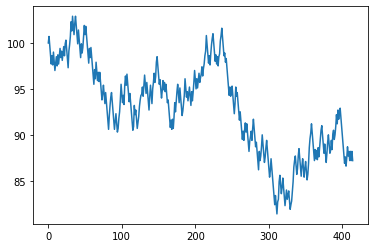

In [1003]:
def kelly(p,b):
    return (p-(1/b))/(1-1/b)

cap = 100
evo = [cap]
odds_won = []
wins = 0

lstreak = 0
mlstreak = 1

rid_won = []

for i in range(len(choice)):
    c = choice[i]
    p = proba[i]
    
    E = p[c-1] * odds[i, c-1] - (1-p[c-1])
    
    sorted_proba = np.argsort(p)
    
    p_ranker = p[choice_ranker[i]-1]
    if str(ids[i]) in rapports:    
        if "SIMPLE_GAGNANT" in rapports[str(ids[i])]:
            if odds[i, c-1] > 0 and p[c-1] > 0.4:
                frackel = np.ceil(max(1, cap * kelly(p[c-1], odds[i, c-1]) /3))
                odds_pmu = rapports[str(ids[i])]["SIMPLE_GAGNANT"]["rapports"]
                for j in odds_pmu:
                    if all([x in [sorted_proba[-1] + 1] for x in j["combinaison"]]):
                        #print("GAGNANT",(j["dividendePourUnEuro"] / 100), j["combinaison"])
                        cap += 1*j["dividendePourUnEuro"] / 100
                        odds_won.append(j["dividendePourUnEuro"] / 100)
                        wins+=1
                        lstreak=0
                        rid_won.append(ids[i])
                cap-=1
                if cap < evo[-1]:
                    lstreak+=1

                
                evo.append(cap)
    mlstreak = max(mlstreak, lstreak)
        


print(f"NB Courses: {len(X_test.rid.unique())}")
print(f"{cap-evo[0]:.0f}€, Max lose streak: {mlstreak}")
print(f"NB Paris: {len(evo)-1}, NB Wins: {wins}, %Wins: {wins/len(evo)*100:.2f}%")
print(f"Mean: {np.mean(odds_won):.2f}, Median: {np.median(odds_won):}, Max: {np.max(odds_won):}, Min: {np.min(odds_won)}")
plt.plot(evo)

In [790]:
X_test.loc[X_test["rid"] == rid_won[0]][["date","nom","numCoursePMU","num","classement","rank_pred","dernierRapportDirect_rapport"]]

,date,nom,numCoursePMU,num,classement,rank_pred,dernierRapportDirect_rapport
0,2022-01-01 00:00:00,HOCKFELER DU MESLE,R1C2,1,10,11,26.0
1,2022-01-01 00:00:00,HARBOUR D'ORGERES,R1C2,2,10,8,6.4
2,2022-01-01 00:00:00,HELENCIO,R1C2,3,3,3,63.0
3,2022-01-01 00:00:00,HOUSTON DE JOUDES,R1C2,4,6,10,13.0
4,2022-01-01 00:00:00,HARD MONEY,R1C2,5,5,4,51.0
5,2022-01-01 00:00:00,HELLO PANAME,R1C2,6,2,6,58.0
6,2022-01-01 00:00:00,HYDROMEL,R1C2,7,4,9,45.0
7,2022-01-01 00:00:00,HETY DU GOUTIER,R1C2,8,10,2,23.0
8,2022-01-01 00:00:00,HAMLET DU VIVIER,R1C2,9,1,5,1.7
9,2022-01-01 00:00:00,HANAMOUR DE CHOUTE,R1C2,10,10,7,13.0


In [334]:
        if "SIMPLE_PLACE" in rapports[str(ids[i])]:
            if p[c-1] > 1/odds[i, c-1]:
                frackel = np.ceil(max(1, cap * kelly(p[c-1], odds[i, c-1]) /3))
                odds_pmu = rapports[str(ids[i])]["SIMPLE_PLACE"]["rapports"]
                for j in odds_pmu:
                    if all([x in [sorted_proba[-1] + 1] for x in j["combinaison"]]):
                        #print("GAGNANT",(j["dividendePourUnEuro"] / 100), j["combinaison"])
                        cap += frackel*j["dividendePourUnEuro"] / 100
                        odds_won.append(j["dividendePourUnEuro"] / 100)
                        wins+=1
                        lstreak=0
                        rid_won.append(ids[i])
                cap-=frackel
                evo.append(cap)
                if cap < evo[-1]:
                    lstreak+=1

0        2022-01-01 00:00:00
1        2022-01-01 00:00:00
2        2022-01-01 00:00:00
3        2022-01-01 00:00:00
4        2022-01-01 00:00:00
                ...         
25713    2022-03-05 00:00:00
25714    2022-03-05 00:00:00
25715    2022-03-05 00:00:00
25716    2022-03-05 00:00:00
25717                      0
Name: date, Length: 25718, dtype: object

In [680]:
rid_won

[2022010175001,
 2022010175002,
 2022010714755,
 2022010975008,
 2022010975009,
 2022011176167,
 2022011206013,
 2022011506012,
 2022011575008,
 2022011675002,
 2022011675005,
 2022011675006,
 2022011769021,
 2022012006014,
 2022012075004,
 2022012075007,
 2022012275005,
 2022012375002,
 2022012606012,
 2022012606017,
 2022012769024,
 2022012769026,
 2022012775001,
 2022012775004,
 2022012806015,
 2022013044132,
 2022013175005,
 2022020133021,
 2022020133027,
 2022020206014,
 2022020206016,
 2022020275005,
 2022020275007,
 2022020369025,
 2022020369027,
 2022020406017,
 2022020449011,
 2022020576165,
 2022020669027,
 2022020706014,
 2022020706016,
 2022020775007,
 2022020850082,
 2022020850085,
 2022020850087,
 2022021075003,
 2022021144138,
 2022021176164,
 2022021206011,
 2022021206017,
 2022021275001,
 2022021275007,
 2022021375007,
 2022021375008,
 2022021506012,
 2022021506014,
 2022021506015,
 2022021506016,
 2022021575006,
 2022021775007,
 2022021806013,
 2022021806017,
 2022021